# The E-SENSING PROJECT
## Data & services##

The e-sensing project is about developing new ways to extract information on land use and land cover change from big Earth Observation data sets. We address the following scientific question: 

***How can we use e-science methods and techniques to improve the extraction of land use and land cover change information from big Earth Observation data sets in an open and reproducible way?*** 

To answer this, our project is building a new generation of knowledge platform for handling big geospatial data. We're conceiving, building, and deploying a new type of knowledge platform for accessing, processing and analysing big Earth Observation data.

We assume that decades of satellite images can be effectively organized into a data structure which can be efficietly queried and processed using the array data model. 

<img src="img/datacube.png" alt="A data cube of satellite images is as an array" title="data cube" height="300" width="400" />

Our approach is to put data and analysis together to help scietists to do larger, longer, and faster research on land use and land cover change.

<img src="img/architecture.png" alt="e-sensing project's architecture " title="e-sensing architecture" height="300" width="400" />

The "e-sensing" project is supported by __[FAPESP](http://bv.fapesp.br/pt/auxilios/89598/e-sensing-analise-de-grandes-volumes-de-dados-de-observacao-da-terra-para-informacao-de-mudancas-de/)__, under the  __[e-science program](http://www.fapesp.br/8436)__ .

For additional info, please visits us at:

- our  __[official page](http://esensing.org/)__ 
- our code at __[github](https://github.com/e-sensing/)__
- our project at __[research gate](https://www.researchgate.net/project/e-sensing-big-earth-observation-data-analytics-for-land-use-and-land-cover-change-information-wwwesensingorg)__


### Web Time Series Service - WTSS

WTSS is a lightweight web service for handling time series data from remote sensing imagery. It exposes 3 operations:
- *list_coverages*: get the list of available coverages.
- *describe_coverage*: get metadata about a specific coverage.
- *time_series*: get a time series for a given location and time interval.

For additional info on the WTSS go __[here](https://github.com/e-sensing/tws/tree/master/src/tws/wtss)__

### WTSS for python


For additional info on the python client for WTSS go __[here](https://github.com/e-sensing/wtss.py)__

In [10]:
# WTSS python client: Access to data & metadata
import pip

def install(package):
   pip.main(['install', package])
install('wtss')
install('pandas')
install('numpy')
install('scipy')

from wtss import wtss
import numpy as np
import scipy as sp
import pandas as pd


w = wtss("http://www.dpi.inpe.br/tws")

# get available data sets
cv_list = w.list_coverages()
for cv_name in cv_list["coverages"]:
    print(cv_name)

# get specific data set
cv_scheme = w.describe_coverage("mod13q1_512")

# get time series of a point
ts = w.time_series("mod13q1_512", ("ndvi", "evi"), -12.0, -54.0)


itobi
merge
mixl8mod
mixl8mod_f
mod13q1_512


In [11]:
# build a data frame
ndvi = pd.Series(ts["ndvi"], index = cv_scheme["timeline"])/10000
evi =  pd.Series(ts["evi"],  index = cv_scheme["timeline"])/10000

vidf = pd.DataFrame({'ndvi' : ndvi, 'evi': evi})
vidf[0:5]


,evi,ndvi
2000-02-18,0.3227,0.5532
2000-03-05,0.3328,0.4512
2000-03-21,0.5831,0.8734
2000-04-06,0.4962,0.8865
2000-04-22,0.5341,0.8859


### Time Series Analysis

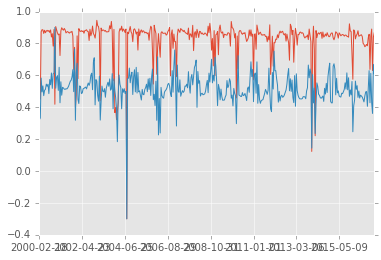

In [12]:
# Time series visualization
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
ndvi.plot()
evi.plot()

In [13]:
# Fourier decomposition

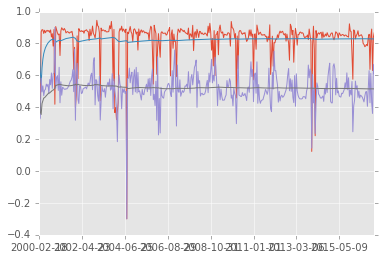

In [14]:
# Kalman filter

def kalmanfilter(vi):
    est   = np.zeros(len(vi))
    e_est = np.zeros(len(vi))
    kg    = np.zeros(len(vi))
    e_mea = vi.std()        # error_in_measurement
    est[0]   = vi.mean()    # initial estimate
    e_est[0] = 3 * vi.std() # initial_error_in_estimate
    kg[0]    = None
    for i in range(1, len(vi)):
        kg[i] = e_est[i - 1]/(e_est[i - 1] + e_mea)    # compute the Kalman gain
        m = vi[i - 1]
        if(np.isnan(m)):
            m = est[i - 1]                             # use the estimation when a measurement is missing
        est[i] = est[i - 1] + kg[i] * (m - est[i - 1]) # compute the new estimation
        e_est[i] = (1 - kg[i]) * e_est[i - 1]
    return est

vidf['ndvi.kf'] = pd.Series(kalmanfilter(ndvi), index = cv_scheme["timeline"])
vidf['evi.kf']  = pd.Series(kalmanfilter(evi), index = cv_scheme["timeline"])

vidf['ndvi'].plot()
vidf['ndvi.kf'].plot()
vidf['evi'].plot()
vidf['evi.kf'].plot()

In [15]:
# DTW & TWDTW

### Other ESENSING projects